In [ ]:
import os
import imghdr
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
data_dir='dataForCas'
os.listdir(data_dir)

['papers', 'plastic', 'electronics']

In [ ]:
image_exts=['jpeg','jpg','bmp','png']
import cv2
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# Data Augmentation

In [ ]:
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# flip vertically
        validation_split=0.2) 



# Load Data 2.0


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('dataForCas')
len(data)


In [ ]:
train=datagen.flow_from_directory(  "dataForCas",  
                                    target_size=(224, 224), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset="training"
)
validation=datagen.flow_from_directory( "dataForCas",  
                                    target_size=(224, 224), 
                                    shuffle=True,
                                    seed=42,
                                    color_mode='rgb', 
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset='validation'
)

In [ ]:
class_names = list(train.class_indices.keys())
class_names

#Download the pretrained model


In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
   include_top=False,
   weights='imagenet',
   input_shape=(224, 224, 3),
  classes=3,
)

94765736/94765736 [==============================] - 0s 0us/step


#Adding new layers + freezing layers


In [ ]:
base_model.trainable = False#freezing

inputs = keras.Input(shape=(224, 224, 3))

# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1100, activation="relu")(x)
x = keras.layers.Dense(1100, activation="relu")(x)
x = keras.layers.Dense(1100, activation="relu")(x)
x = keras.layers.Dense(550, activation ="relu")(x)

# A Dense classifier with a multiclass classification 
outputs = Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1100)              2253900   
                                                                 
 dense_11 (Dense)            (None, 1100)              1211100   
                                                                 
 dense_12 (Dense)            (None, 1100)              1211100   
                                                           

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
my_callbacks  =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                             min_delta=1e-3, patience=10)

In [ ]:
history = model.fit(train,
          validation_data=validation,
        epochs=20)

Epoch 1/20
11/11 [==============================] - 148s 11s/step - loss: 0.9007 - accuracy: 0.5710 - val_loss: 0.6172 - val_accuracy: 0.8395
Epoch 2/20
11/11 [==============================] - 113s 10s/step - loss: 0.4643 - accuracy: 0.8912 - val_loss: 0.3182 - val_accuracy: 0.9506
Epoch 3/20
11/11 [==============================] - 114s 10s/step - loss: 0.2643 - accuracy: 0.9184 - val_loss: 0.1747 - val_accuracy: 0.9383
Epoch 4/20
11/11 [==============================] - 113s 10s/step - loss: 0.1699 - accuracy: 0.9456 - val_loss: 0.1035 - val_accuracy: 0.9753
Epoch 5/20
11/11 [==============================] - 113s 10s/step - loss: 0.1286 - accuracy: 0.9517 - val_loss: 0.1048 - val_accuracy: 0.9753
Epoch 6/20
11/11 [==============================] - 113s 10s/step - loss: 0.1034 - accuracy: 0.9668 - val_loss: 0.0786 - val_accuracy: 0.9753
Epoch 7/20
11/11 [==============================] - 112s 10s/step - loss: 0.1097 - accuracy: 0.9668 - val_loss: 0.0946 - val_accuracy: 0.9506
Epoch 

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

Number of layers in the base model:  175


In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 20
total_epochs =  20 + fine_tune_epochs


In [ ]:
history_fine = model.fit(train,
                         epochs=total_epochs,
                         callbacks=my_callbacks,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation,)

Epoch 20/40


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 122s 10s/step - loss: 0.1068 - accuracy: 0.9758 - val_loss: 0.1208 - val_accuracy: 0.9630
Epoch 21/40
11/11 [==============================] - 114s 10s/step - loss: 0.0051 - accuracy: 0.9970 - val_loss: 0.0624 - val_accuracy: 0.9877
Epoch 22/40
11/11 [==============================] - 113s 10s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0896 - val_accuracy: 0.9877
Epoch 23/40
11/11 [==============================] - 113s 10s/step - loss: 3.9091e-04 - accuracy: 1.0000 - val_loss: 0.1297 - val_accuracy: 0.9877
Epoch 24/40
11/11 [==============================] - 114s 10s/step - loss: 5.2775e-04 - accuracy: 1.0000 - val_loss: 0.0879 - val_accuracy: 0.9877
Epoch 25/40
11/11 [==============================] - 113s 10s/step - loss: 3.0739e-04 - accuracy: 1.0000 - val_loss: 0.1066 - val_accuracy: 0.9877
Epoch 26/40
11/11 [==============================] - 113s 10s/step - loss: 1.4220e-04 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 0.

In [ ]:
# function to plot the results of the model
def show_results() :
    #Plot the Graph
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

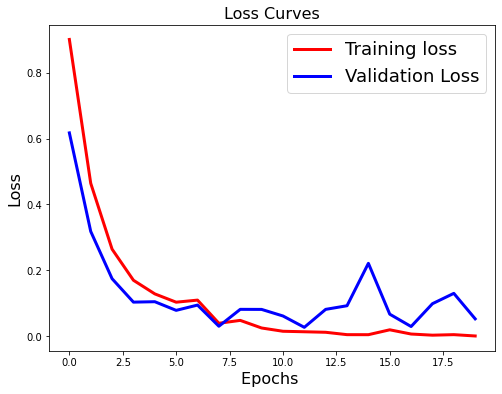

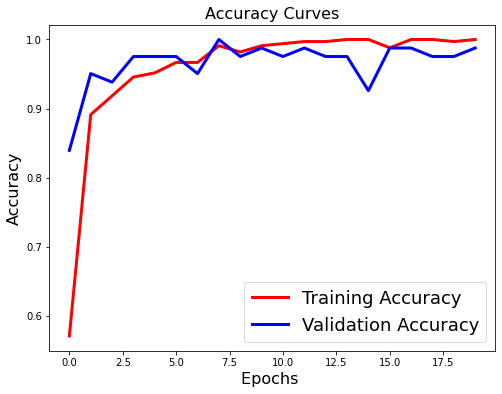

In [ ]:
show_results()

#Prediction

In [ ]:
#functions to show_image and make_predictions
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 0s 186ms/step


'plastic'

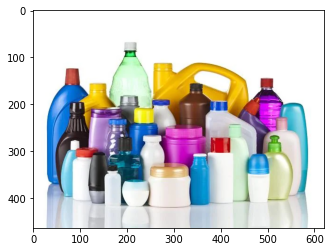

In [ ]:
class_names[np.argmax(make_predictions("image1.jpg"))]

1/1 [==============================] - 0s 185ms/step


'electronics'

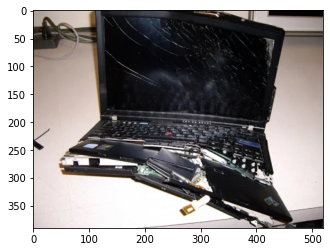

In [ ]:
class_names[np.argmax(make_predictions("image2.jpg"))]

1/1 [==============================] - 0s 182ms/step


'papers'

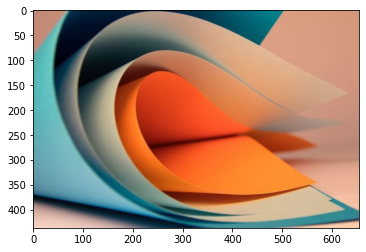

In [ ]:
class_names[np.argmax(make_predictions("image3.jpg"))]

1/1 [==============================] - 0s 195ms/step


'electronics'

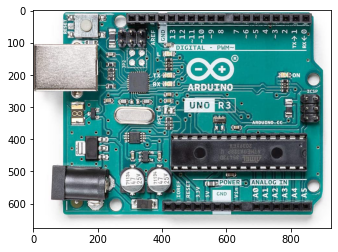

In [ ]:
class_names[np.argmax(make_predictions("image4.jpg"))]

1/1 [==============================] - 0s 182ms/step


'plastic'

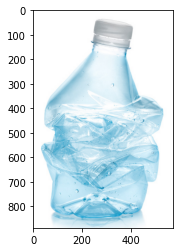

In [ ]:
class_names[np.argmax(make_predictions("image5.png"))]

1/1 [==============================] - 0s 197ms/step


'papers'

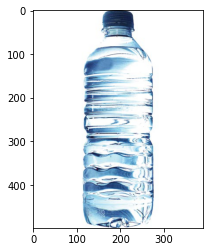

In [ ]:
class_names[np.argmax(make_predictions("water.jpg"))]

1/1 [==============================] - 0s 182ms/step


'plastic'

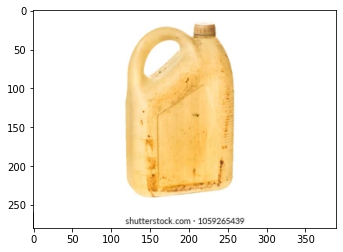

In [ ]:
class_names[np.argmax(make_predictions("plastic2.jpg"))]